# DART 보험사 재무제표 자동 다운로드 및 분석 프로그램 개발

In [58]:
from bs4 import BeautifulSoup
from selenium import webdriver
import requests
import re
import pandas as pd
import time
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
import OpenDartReader
import os
import seaborn as sns
import sys

In [59]:
api_key = '31718c7bf232574ee78e6f3f81c922043baad322'
dart = OpenDartReader(api_key)

sys.maxsize
set_matplotlib_formats('retina')
pd.options.display.max_rows = 50
plt.rc('font', family='Malgun Gothic')
plt.rc('axes', unicode_minus = False)

pd.options.display.float_format = '{:.2f}'.format
pd.options.display.max_columns = 60
pd.options.display.max_rows = 200

headers = {'user-agent':'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/88.0.4324.104 Safari/537.36'}
options = webdriver.ChromeOptions()
options.headless = True
options.add_argument('window-size=1920x1080')
options.add_argument('user-agent=Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/87.0.4280.88 Safari/537.36')

#  opendart 이용, 보고서 이름과 rcept_no, 회사 이름 리스트 형식 변환

In [3]:
corp_code = {'삼성생명':'032830',
            '한화생명':'088350'}

dart_list = dart.list(corp_code['한화생명'], start='1999-01-01', kind='A') # 분석하고자 하는 회사 명

report_type_dict = {
    '사업보고서':'A001',
    '반기보고서':'A002',
    '분기보고서':'A003',
}

data_size = 3 # 몇 기간의 데이터를 가져올 건지 결정
report_type_selected = list(report_type_dict.keys())[1] # 1 : 반기보고서

dart_list = dart_list[['corp_name','report_nm','rcept_no']]
dart_list_selected = dart_list[dart_list['report_nm'].str.contains(report_type_selected)].copy()

In [4]:
corp_nms = list(dart_list_selected['corp_name'])
corp_nm = corp_nms[0] # 회사 이름 

report_nms = list(dart_list_selected['report_nm'])
report_nm = report_nms[0] # 리포트 이름 : 반기보고서 (2020.09)

search_df_nms = ['포괄손익계산서','재무상태표','현금흐름표','자본변동표']
search_df_nm = f'{corp_nm} {search_df_nms[0]}' # 분석하려는 보고서 유형

rcept_nos = list(dart_list_selected['rcept_no'])

In [5]:
date_list = list(dart_list_selected['report_nm'].str.split(' ').str[-1])

date_list_mod=[]

for i, val in enumerate(date_list):
    date = date_list[i].replace('(','').replace(')','')
    date_list_mod.append(date)

In [6]:
df_date = pd.Series(date_list_mod)

# url 딕셔너리 설정

In [7]:
urls = []

for rcpNo in rcept_nos:
    url = 'http://dart.fss.or.kr/dsaf001/main.do?rcpNo={}'.format(rcpNo)

    params = {
        'crtfc_key' : '31718c7bf232574ee78e6f3f81c922043baad322',
        'corp_code' : '032830',
        'bgn_de' : '19990101',
        'pblntf_detail_ty': '{}'.format(report_type_dict[report_type_selected]),
        'page_count': '100',
    }

    res = requests.get(url,params=params, headers = headers)
    res.raise_for_status()
    
    urls.append(res.url)

# 제무제표 데이터 추출

## 재무제표 파일 다운로드하는 data_to_csv 함수 만들기

### selenium 활용 파일 다운로드 함수

In [8]:
def rawdata_to_csv(urls):
    for i, url in enumerate(urls):
        browser = webdriver.Chrome(options = options)
        browser.maximize_window()
        browser.get(url)

        browser.find_element_by_xpath('//*[@id="ext-gen10"]/div/li[5]/ul/li[2]/div/a/span').click()
        iframes = browser.find_elements_by_tag_name('iframe')
        browser.switch_to.frame(iframes[0])
        html = browser.page_source

        report_nm = report_nms[i]
        tables = pd.read_html(html)

        df_list= list()

        for idx, v in enumerate(tables):
            if idx in [0,2,4,6]:
                pass
            else:
                df = tables[idx]
                df_list.append(df)

            for index, value in enumerate(df_list):
                if index == 0:
                    df_nm = '연결 재무상태표'
                elif index == 1:
                    df_nm = '연결 포괄손익계산서'
                elif index == 2:
                    df_nm = '자본변동표'
                else:
                    df_nm = '현금흐름표'

                df_list[index].to_csv(f'{corp_nm} {df_nm} {report_nm}.csv', encoding='utf-8-sig')
    browser.quit()

### url 사이즈 선택

In [21]:
urls = urls[:data_size]
rawdata_to_csv(urls)

# 재무제표 데이터 수정, 병합, 통합 파일 저장

## merge 위해 데이터 수정

In [19]:
data_list = os.listdir()

match_list = list()

for df_nm in data_list:
    if search_df_nm in df_nm:
        match_list.append(df_nm)
        
match_list      

['연결 포괄손익계산서 한화생명 반기보고서 (2018.06).csv',
 '연결 포괄손익계산서 한화생명 반기보고서 (2019.06).csv',
 '연결 포괄손익계산서 한화생명 반기보고서 (2020.06).csv']

## 데이터 전처리 후 통합 및 파일 저장

In [ ]:
df_list = list()

if corp_nm == '삼성생명':
    for i, df_nm in enumerate(match_list):
        df = pd.read_csv('./{}'.format(df_nm), encoding='utf-8-sig')
        if corp_nm == '삼성생명':
            df = df.iloc[:,1:3]
            df = df[df['과 목'].notnull()]
            df['과 목'] = df['과 목'].str.split('.').str[-1]
            df['과 목'] = df['과 목'].str.split('(').str[0]
            df['과 목'] = df['과 목'].str.strip().copy()
            df.rename(columns = {'과 목' : '계정과목'}, inplace = True)
            df_list.append(df)
else:
    for i, df_nm in enumerate(match_list):
        df = pd.read_csv('./{}'.format(df_nm), encoding='utf-8-sig')
        df = df.drop(0) # 여기서 부터 타보험사 수정
        df = df.iloc[:,1:5].drop('주 석', axis=1)
        df = df.iloc[:,::2]
        df = df[df['과 목'].notnull()]
        df['과 목'] = df['과 목'].str.split('.').str[-1]
        df['과 목'] = df['과 목'].str.split('(').str[0]
        df['과 목'] = df['과 목'].str.strip().copy()
        df.rename(columns = {'과 목' : '계정과목'}, inplace = True)
        df_list.append(df)

### 다운로드 받은 raw data read후 전처리

In [83]:
# 한화생명 단위 : 원
# 삼성생명 단위 : 백만 원 , 단위 모두 백만 원으로 처리하자.

df_list = list()

    for i, df_nm in enumerate(match_list):
        df = pd.read_csv('./{}'.format(df_nm), encoding='utf-8-sig')
        if corp_nm == '삼성생명':
            df = df.iloc[:,1:3]
            df = df[df['과 목'].notnull()]
        else:
            df = df.drop(0) # 타보험사 수정
            df = df.iloc[:,1:5].drop('주 석', axis=1)
            df = df.iloc[:,::2]
            
        df['과 목'] = df['과 목'].str.split('.').str[-1]
        df['과 목'] = df['과 목'].str.split('(').str[0]
        df['과 목'] = df['과 목'].str.strip().copy()
        df.rename(columns = {'과 목' : '계정과목'}, inplace = True)
        df_list.append(df)

### colunm to index

In [84]:
df_list_index = list()

for i, val in enumerate(df_list):
    df_index = df_list[i].set_index('계정과목').copy()
    df_list_index.append(df_index)

### join 으로 data 통합 ( 각 보고 시점에만 존재하는 계정들은 제외, merge 에서 left, right_index = True & how = 'inner'와 같음)

In [85]:
for i, val in enumerate(df_list_index):
    if i == 0:
        df_join = df_list_index[i]
    elif i <= len(df_list_index):
        df_join = df_join.join(df_list_index[i])
    else:
        continue

## 중복행 제거 및 첫 번째 열 제거 

### 중복행 제거 및 칼럼 날짜 데이터로 변경

In [87]:
df_date_cols = df_date.loc[:len(match_list)-1].sort_index(ascending=False)

In [88]:
date_cols = pd.to_datetime(df_date_cols)
df_join = df_join.reset_index().copy()
df_join_dup = df_join.drop_duplicates('계정과목', keep="first").copy()
df_join_dup = df_join_dup.set_index(['계정과목']).copy()
df_join_dup.columns = df_date_cols

In [89]:
df_join_dup

,2018.06,2019.06,2020.06
계정과목,,,
관계기업의 기타포괄손익지분,2685248736,NaN,NaN
구상이익,3662690031,2440139433,481094279
기타비용,235606141543,231919535535,215766167808
기타수익,422129747727,442462314677,377465498448
기타포괄손익,"(209,391,549,199)",NaN,NaN
당기손익으로 재분류되지 않는 포괄손익,4167704967,2757892856,1925880441
당기손익인식유가증권 평가 및 처분손실,14701587288,32605824062,112334736872
당기손익인식유가증권 평가 및 처분이익,63567458019,92825717784,70889230593
대출채권및수취채권 평가 및 처분손실,9170841720,58624075072,65944841774


### 데이터프레임 transpose 및 내부 데이터 int 형으로 변경

In [90]:
def str_to_int(x):
    if isinstance(x, str):
        x = x.replace('-','0')
        x = x.replace('(','-')
        x = x.replace(')','')
        x = x.replace(',','')
        x = int(x)
    return x

In [91]:
df_join_t = df_join_dup.T.fillna(0)
for i in range(len(df_join_t.index)):
    df_join_t.iloc[i] = df_join_t.iloc[i].apply(str_to_int)

In [92]:
df_join_t = df_join_t / 1000000

계정과목,관계기업의 기타포괄손익지분,구상이익,기타비용,기타수익,기타포괄손익,당기손익으로 재분류되지 않는 포괄손익,당기손익인식유가증권 평가 및 처분손실,당기손익인식유가증권 평가 및 처분이익,대출채권및수취채권 평가 및 처분손실,만기보유금융자산평가손익,매도가능금융자산평가손익,매도가능유가증권 평가 및 처분손실,매도가능유가증권 평가 및 처분이익,반기순이익,반기순이익의 귀속,반기총포괄손익,반기총포괄손익의 귀속,법인세비용,법인세비용차감전순이익,보통주 기본주당순이익,보험계약부채전입액,보험료수익,비지배지분,사업비,손해조사비,신계약비상각비,영업비용,영업수익,영업외비용,영업외수익,영업이익,외환거래 및 환산손실,외환거래 및 환산이익,위험회피목적파생상품평가손익,유형자산재평가이익,이자수익,재보험비용,재보험수익,재산관리비,주당이익,지급보험금,지배기업의 소유주,특별계정기타포괄손익,특별계정비용,특별계정수익,특별계정수입수수료,특별계정지급수수료,파생상품 평가 및 거래손실,파생상품평가 및 거래이익,해외사업장환산외환차이,후속적으로 당기손익으로 재분류될 수 있는 포괄손익
2018.06,2685248736,3662690031,235606141543,422129747727,-209391549199,4167704967,14701587288,63567458019,9170841720,-50838570850,-235807459426,64765282557,158539885151,303000986789,303000986789,93609437590,93609437590,139954579508,442955566297,301,2169576680545,7445382590767,55206272990,893027062233,50963537712,671186189523,11767729911471,12206324712232,22245833644,26606599180,438594800761,97439946723,1115017911055,70585037696,4167704967,1523883434188,714689050164,688006555654,57459202927,0,5587905202787,247794713799,-8747202528,106907092853,108055069932,601826946034,11879055522,1082453037374,76252423674,8563692206,-213559254166
2019.06,0,2440139433,231919535535,442462314677,0,2757892856,32605824062,92825717784,58624075072,0,0,284097515018,200331867080,88721972118,0,921323488466,921323488466,12194968375,100916940493,0,2156184200309,7737445283597,-1400037872,988012125086,55425360448,645680256958,12537229723297,12631283874806,31776987070,38639776054,94054151509,0,0,0,0,1482700707390,764286200414,683487516151,73188285445,0,5764440899278,90122009990,0,121731870623,123253978840,475807953320,11100083156,0,220884989378,0,0
2020.06,0,481094279,215766167808,377465498448,0,1925880441,112334736872,70889230593,65944841774,0,0,198043227805,649343985023,162726095404,0,1062193486785,1062193486785,55431668436,218157763840,0,2285804050214,8102274397804,4225411894,1015146368059,56442266234,621055809980,13457529960780,13680290409294,17739726288,13137041614,222760448514,0,0,0,0,1491854491203,747414700440,714597132529,71600006726,0,6229515908422,158500683510,0,98064605754,98064605754,507108524409,29212680181,0,296218996973,0,0


In [93]:
df_join_t = df_join_t.astype(float).copy()

### 통합 파일 저장

In [94]:
df_join_t.to_csv(f'{corp_nm}_{report_type_selected}_통합파일.csv', encoding='utf-8-sig')

# merged data 분석 및 시각화

## 데이터 전처리

### 칼럼명 및 보고시점 칼럼 내용 수정

In [96]:
df = pd.read_csv("./{}_{}_통합파일.csv".format(search_df_nm,report_type_selected))

In [97]:
df = df.rename(columns={'Unnamed: 0':'보고시점'}).copy()
df['보고시점'] = df.iloc[:,0].str.replace('-01','')

AttributeError: Can only use .str accessor with string values!

In [104]:
df

,보고시점,관계기업의 기타포괄손익지분,구상이익,기타비용,기타수익,기타포괄손익,당기손익으로 재분류되지 않는 포괄손익,당기손익인식유가증권 평가 및 처분손실,당기손익인식유가증권 평가 및 처분이익,대출채권및수취채권 평가 및 처분손실,만기보유금융자산평가손익,매도가능금융자산평가손익,매도가능유가증권 평가 및 처분손실,매도가능유가증권 평가 및 처분이익,반기순이익,반기순이익의 귀속,반기총포괄손익,반기총포괄손익의 귀속,법인세비용,법인세비용차감전순이익,보통주 기본주당순이익,보험계약부채전입액,보험료수익,비지배지분,사업비,손해조사비,신계약비상각비,영업비용,영업수익,영업외비용,영업외수익,영업이익,외환거래 및 환산손실,외환거래 및 환산이익,위험회피목적파생상품평가손익,유형자산재평가이익,이자수익,재보험비용,재보험수익,재산관리비,주당이익,지급보험금,지배기업의 소유주,특별계정기타포괄손익,특별계정비용,특별계정수익,특별계정수입수수료,특별계정지급수수료,파생상품 평가 및 거래손실,파생상품평가 및 거래이익,해외사업장환산외환차이,후속적으로 당기손익으로 재분류될 수 있는 포괄손익
0,2018.06,2685248736.00,3662690031.00,235606141543.00,422129747727.00,-209391549199.00,4167704967.00,14701587288.00,63567458019.00,9170841720.00,-50838570850.00,-235807459426.00,64765282557.00,158539885151.00,303000986789.00,303000986789.00,93609437590.00,93609437590.00,139954579508.00,442955566297.00,301.00,2169576680545.00,7445382590767.00,55206272990.00,893027062233.00,50963537712.00,671186189523.00,11767729911471.00,12206324712232.00,22245833644.00,26606599180.00,438594800761.00,97439946723.00,1115017911055.00,70585037696.00,4167704967.00,1523883434188.00,714689050164.00,688006555654.00,57459202927.00,0.00,5587905202787.00,247794713799.00,-8747202528.00,106907092853.00,108055069932.00,601826946034.00,11879055522.00,1082453037374.00,76252423674.00,8563692206.00,-213559254166.00
1,2019.06,0.00,2440139433.00,231919535535.00,442462314677.00,0.00,2757892856.00,32605824062.00,92825717784.00,58624075072.00,0.00,0.00,284097515018.00,200331867080.00,88721972118.00,0.00,921323488466.00,921323488466.00,12194968375.00,100916940493.00,0.00,2156184200309.00,7737445283597.00,-1400037872.00,988012125086.00,55425360448.00,645680256958.00,12537229723297.00,12631283874806.00,31776987070.00,38639776054.00,94054151509.00,0.00,0.00,0.00,0.00,1482700707390.00,764286200414.00,683487516151.00,73188285445.00,0.00,5764440899278.00,90122009990.00,0.00,121731870623.00,123253978840.00,475807953320.00,11100083156.00,0.00,220884989378.00,0.00,0.00
2,2020.06,0.00,481094279.00,215766167808.00,377465498448.00,0.00,1925880441.00,112334736872.00,70889230593.00,65944841774.00,0.00,0.00,198043227805.00,649343985023.00,162726095404.00,0.00,1062193486785.00,1062193486785.00,55431668436.00,218157763840.00,0.00,2285804050214.00,8102274397804.00,4225411894.00,1015146368059.00,56442266234.00,621055809980.00,13457529960780.00,13680290409294.00,17739726288.00,13137041614.00,222760448514.00,0.00,0.00,0.00,0.00,1491854491203.00,747414700440.00,714597132529.00,71600006726.00,0.00,6229515908422.00,158500683510.00,0.00,98064605754.00,98064605754.00,507108524409.00,29212680181.00,0.00,296218996973.00,0.00,0.00


Text(0.5, 1.0, '한화생명 반기보고서')

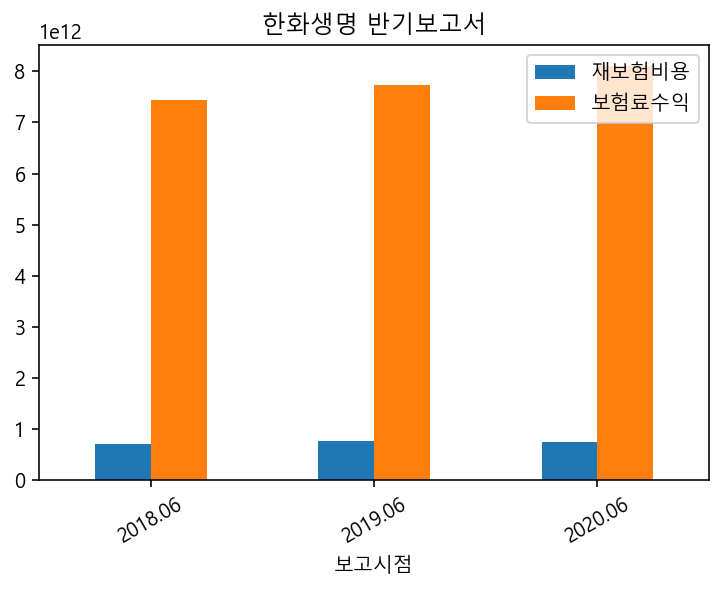

In [107]:
g = df.groupby('보고시점')[['재보험비용','보험료수익']].mean()
g.plot.bar(rot=30).set_title(f'{corp_nm} {report_type_selected}')

In [100]:
p =df.pivot_table(['영업이익','보험료수익'],index = '보고시점', margins=True, aggfunc = sum, fill_value = 0)

## 데이터 시각화

In [ ]:
sns.barplot(data=df, x='보고시점', y='영업이익')